# Cluster Analysis

This is a sample solution for the association rule mining exercise. This does not mean that this is the only way to solve this exercise. As with any programming task - and also with most data analysis tasks - there are multiple solutions for the same problem. 


## Libraries and Data

We use the boston house price data in this exercise. The data is available as part of ```sklearn``` for [Python](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets).

Last week we explored the boston data, this week we use it for clustering. You will apply both $k$-means clustering and DB clustering to the boston data using all fourteen columns. Functions for all clustering algorithms are available in ```sklearn``` for Python. If you experience problems, ensure that your ```sklearn``` version is at least 0.22, your ```matplotlib``` version is at least 3.0.1, and your ```seaborn``` version is at least 0.9.0. 

There are a couple of problems with clustering data like the boston data, that you will have to solve during this exercise.
- The different features of the data are on different scales, which influences the results. 
- The data has fourteen dimensions. This makes visualizing the clusters difficult. You can try a dimension reduction technique like Principle Component Analysis (PCA) to get only two dimensions or use pair-wise plots. Both have advantages and drawbacks, which you should explore as part of this exercise. 

Variance explained by the principle components: [0.46757068 0.11782371]
Ratio of variance explained:  0.5853943917417506


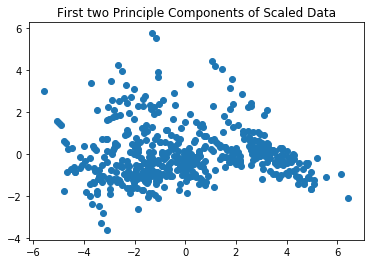

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler



# first we load the data and print description
boston = datasets.load_boston()
boston_df = pd.DataFrame(boston.data, columns=boston.feature_names)
boston_df['TARGET'] = boston.target

# we rescale the data by substracting the mean value and dividing by the standard deviation
# this is known as z-score standardization
scaler = StandardScaler()
boston_scaled = scaler.fit_transform(boston_df)

# principle component analysis computes a linear transformation such that the
# few dimensions of the data explain the majority of the variance
# this can be used to visualize data in 2d, even though there are more dimensions
# the problem is: we do not know what the dimensions mean, because they are not our features
pca = decomposition.PCA(n_components=2)
boston_pca = pca.fit_transform(boston_scaled)
print("Variance explained by the principle components:", pca.explained_variance_ratio_)
print("Ratio of variance explained: ", sum(pca.explained_variance_ratio_))

plt.figure()
plt.scatter(x=boston_pca[:,0], y=boston_pca[:,1])
plt.title("First two Principle Components of Scaled Data")
plt.show()

The PCA gives us no indication regarding the number of clusters. More data exploration of the boston data is done in the data exploration exercise. From that exercise, we know that the scatterplots also do not give a good indication regarding the number of clusters. Thus, we need to explore this based on actual clustering results. 

## $k$-Means Clustering

Use $k$-Means to cluster the data and find a suitable number of clusters for $k$. Use a combination of knowledge you already have about the data, visualizations, as well as the within-sum-of-squares to determine a suitable number of clusters. 

We use the scaled data for $k$-Means clustering to account for scale effects. We use the WSS to determine candidates for the number of clusters.

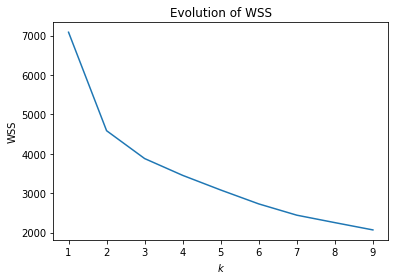

In [17]:
from sklearn.cluster import KMeans

inertia = []
k = range(1,10)
for iter in k:
    kmeans = KMeans(n_clusters=iter, random_state=2)
    kmeans.fit(boston_scaled)
    y_kmeans = kmeans.predict(boston_scaled)
    centers = kmeans.cluster_centers_
    inertia.append(kmeans.inertia_ ) # we already store this for later, inertia=WSS

plt.figure()
plt.title("Evolution of WSS")
plt.plot(k, inertia)
plt.ylabel("WSS")
plt.xlabel("$k$")
plt.xticks(k)
plt.show()

Based on the plot, three or four clusters seem reasonable. We now look at these clusters using the PCA. 

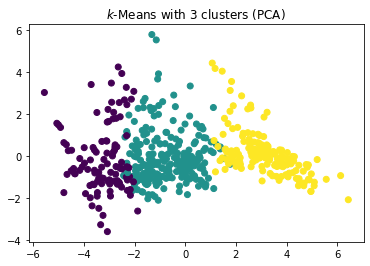

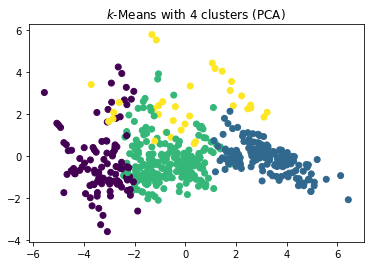

In [12]:
kmeans = KMeans(n_clusters=3, random_state=2)
kmeans.fit(boston_scaled)
y_kmeans = kmeans.predict(boston_scaled)

plt.figure()
plt.scatter(x=boston_pca[:,0], y=boston_pca[:,1], c=y_kmeans)
plt.title("$k$-Means with 3 clusters (PCA)")
plt.show()

kmeans = KMeans(n_clusters=4, random_state=2)
kmeans.fit(boston_scaled)
y_kmeans = kmeans.predict(boston_scaled)
centers = kmeans.cluster_centers_

plt.figure()
plt.scatter(x=boston_pca[:,0], y=boston_pca[:,1], c=y_kmeans)
plt.title("$k$-Means with 4 clusters (PCA)")
plt.show()

The plot of the clusters in the first two principle components indicates that three clusters is the better choice. With three clusters we see a relatively clear separation of the clusters in the plots. With four clusters, there seems to be a relatively random cluster (yellow), that is overlapping with all three other clusters. This may be due to artificially splitting the clusters more than they should be.

From the PCA, we cannot infer if the three clusters have any meaning, i.e., what they represent in the data. To infer this, we now look at a pairwise scatterplot of the clusters with all features. 

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


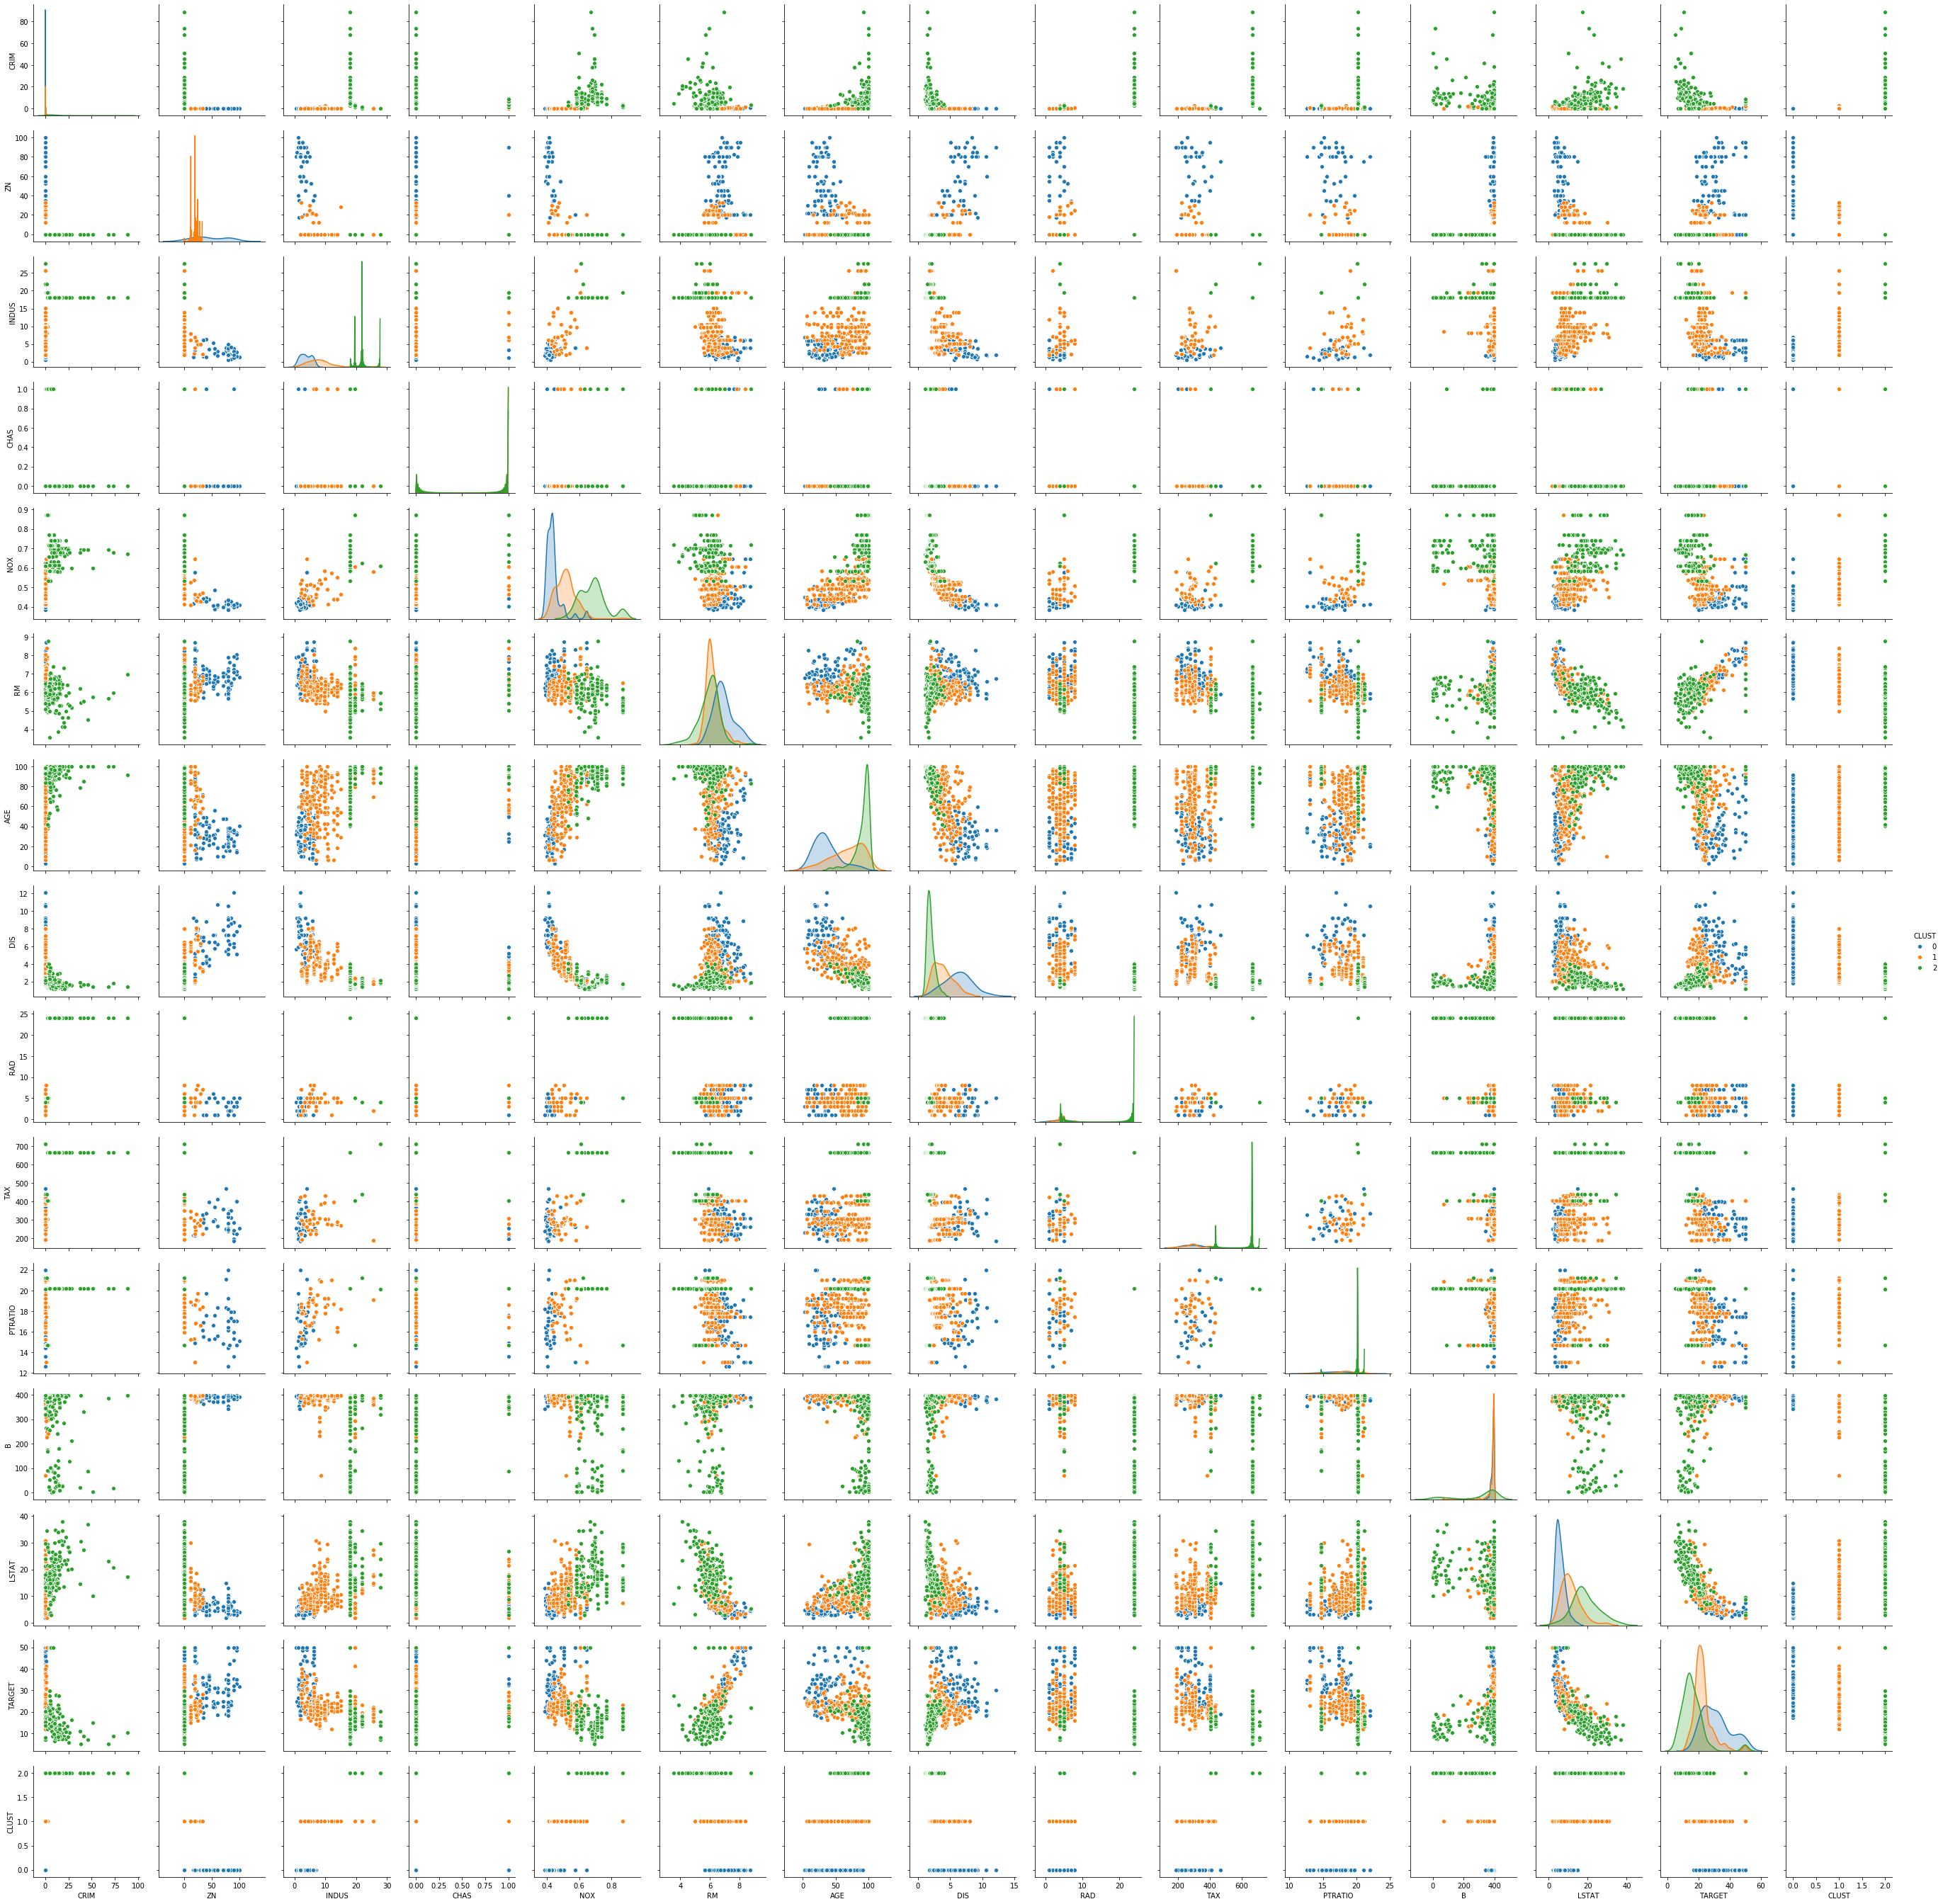

In [5]:
kmeans = KMeans(n_clusters=3, random_state=2)
kmeans.fit(boston_scaled)
y_kmeans = kmeans.predict(boston_scaled)

boston_df_kmeans = boston_df.copy()
boston_df_kmeans['CLUST'] = y_kmeans
sns.pairplot(boston_df_kmeans, hue='CLUST')

The pairwise plots of the fourteen features provide a large amount of information. The main problem with such a plot is knowing where to start learning about the clusters. My suggestion is to first see if there are clear separations between the clusters in the density plots on the diagonal, because this can tell us a lot about the distribution of the data within the clusters. For example, we can learn the following: 

- The blue cluster has the lowest values for INDUS, NOX, AGE and LSTAT and the largest values for ZN and DIS. Thus, the regions in this cluster have only little industry and office space, a low pollution, new houses, a less people with a low degree of education, and a large distance to employment centers and large proportion of houses for residents. 
- The green cluster is more or less the opposite of the blue cluster. The regions have largest proportion of industry and office space, the most pollution, the oldest houses, the lowest degree of eduction and are closest to the employment centers. 
- The orange cluster is somewhere between blue and green in all these features. 

Thus, we already get a fairly good description of the clusters just by analyzing the diagonal: blue seems to be suburbs and rural areas, green is the city center and industrial areas, and orange are the suburbs very close to the city and the outer regions of the city. 

We can further comfirm this by looking at the scatterplots. While the density plots indicate how well the clusters can be separated from each other if a single feature is considered, the scatterplots show the separation of the clusters with two features at once. Based on the analysis from above, we should see a clear separation between blue and green in the scatterplot of INDUS and NOX, whereas orange should be in the middle of both with possible overlaps with both clusters. We can see that the separation is very clear, even between green and orange. This further confirms the hypothesis about the clusters. This kind of visual analysis can be done with any clustering algorithm. 

A different way to look at the results of the clustering is to consider the values of the centers. 

In [15]:
pd.DataFrame(kmeans.cluster_centers_, columns=boston_df.columns)

CRIM        ZN     INDUS      CHAS       NOX        RM       AGE  \
0 -0.407993  1.516136 -1.069871 -0.049523 -0.997236  0.924923 -1.168782   
1 -0.376463 -0.342050 -0.297142  0.011287 -0.334920 -0.092372 -0.029696   
2  0.805442 -0.487722  1.119096  0.015767  1.126513 -0.464891  0.798165   

        DIS       RAD       TAX   PTRATIO         B     LSTAT    TARGET  
0  1.196052 -0.598919 -0.662294 -0.744519  0.354232 -0.949036  0.979868  
1  0.057015 -0.580969 -0.603617 -0.086998  0.286587 -0.180297  0.035814  
2 -0.855104  1.223134  1.296687  0.606407 -0.641361  0.872853 -0.684867

The problem with the values of the centers is that these are for the scaled data. This hinders the interpretation of the values. Thus, we should undo the scaling, before we interpret these values. 

In [17]:
pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=boston_df.columns)

CRIM            ZN      INDUS      CHAS       NOX        RM  \
0   0.107626  4.668868e+01   3.804340  0.056604  0.439252  6.933858   
1   0.378562  3.394068e+00   9.100297  0.072034  0.515924  6.219797   
2  10.534719 -1.776357e-15  18.806585  0.073171  0.685104  5.958317   

         AGE       DIS        RAD         TAX    PTRATIO           B  \
0  35.707547  6.311092   4.339623  296.726415  16.845283  388.981604   
1  67.739831  3.914981   4.495763  306.605932  18.267373  382.812119   
2  91.020122  1.996222  20.189024  626.560976  19.767073  298.178963   

       LSTAT     TARGET  
0   5.882642  31.535849  
1  11.366822  22.861864  
2  18.880000  16.240244

We can see the clear separation of the centers in the variables we expect, but also in some others, e.g., RAD, even though this is not clearly visible and in the scatterplots. Such difference should be considered carefully and not overstated. If the differences cannot be seen in the data, this could also mean that there is no real difference between the cluster for that feature and that the actual location of the centers is random for the feature. 

> Note:
>
> While values like -1.77e-15 are technically negative and non-zero, we note that this is very close to exactly zero. That this is not exactly zero is usually the result of the imprecision of floating point operations. Thus, it it reasonable to assume that this would be exactly zero, while analyzing the data. 

## EM Clustering

(Note: EM clustering is also known as Gaussian Mixture Models and can be found in the mixture package of ```sklearn```.)

Use the EM algorithm to determine multivariate clusters in the data. Determine a suitable number of clusters using the Bayesian Information Criterion (BIC). 

While EM clustering can deal to some degree with scale effects due to the covariances, we still use the scaled data for better comparability with the results of the other clustering algorithms. We start by looking for suitable number of clusters using the BIC. 

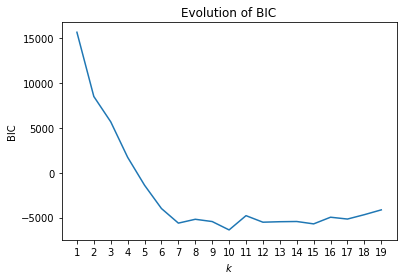

In [18]:
from sklearn.mixture import GaussianMixture

ks=range(1,20)
bic = []
for k in ks:
    em = GaussianMixture(n_components=k,random_state=42)
    em.fit(boston_scaled)
    bic.append(em.bic(boston_scaled))

plt.figure()
plt.title("Evolution of BIC")
plt.plot(ks, bic)
plt.ylabel("BIC")
plt.xlabel("$k$")
plt.xticks(ks)
plt.show()

The BIC clearly indicates that seven would be the optimal number of clusters. While 10 has a slightly lower BIC than 7, the chart indicates that BIC leveled off at seven and that the BIC between 7 and 15 is more or less constant with smaller random fluctuations. We start by analyzing the clustering results with the PCA.

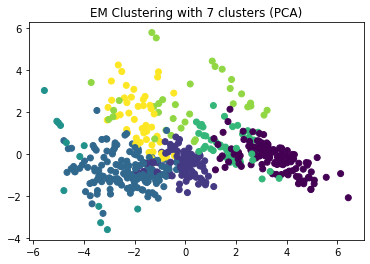

In [43]:
em = GaussianMixture(n_components=7,random_state=42)
em.fit(boston_scaled)
y_em = em.predict(boston_scaled)

plt.figure()
plt.scatter(x=boston_pca[:,0], y=boston_pca[:,1], c=y_em)
plt.title("EM Clustering with 7 clusters (PCA)")
plt.show()

There seems to a fairly good separation between most clusters. Some clusters (toirtoise on the bottom left, green between the two purple clusters) are not well separated from others, but it looks like these are clusters in the border regions of other clusters. We now look at the scatterplots in order to determine if the seven clusters are a good choice and what the meaning of the clusters is. 

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


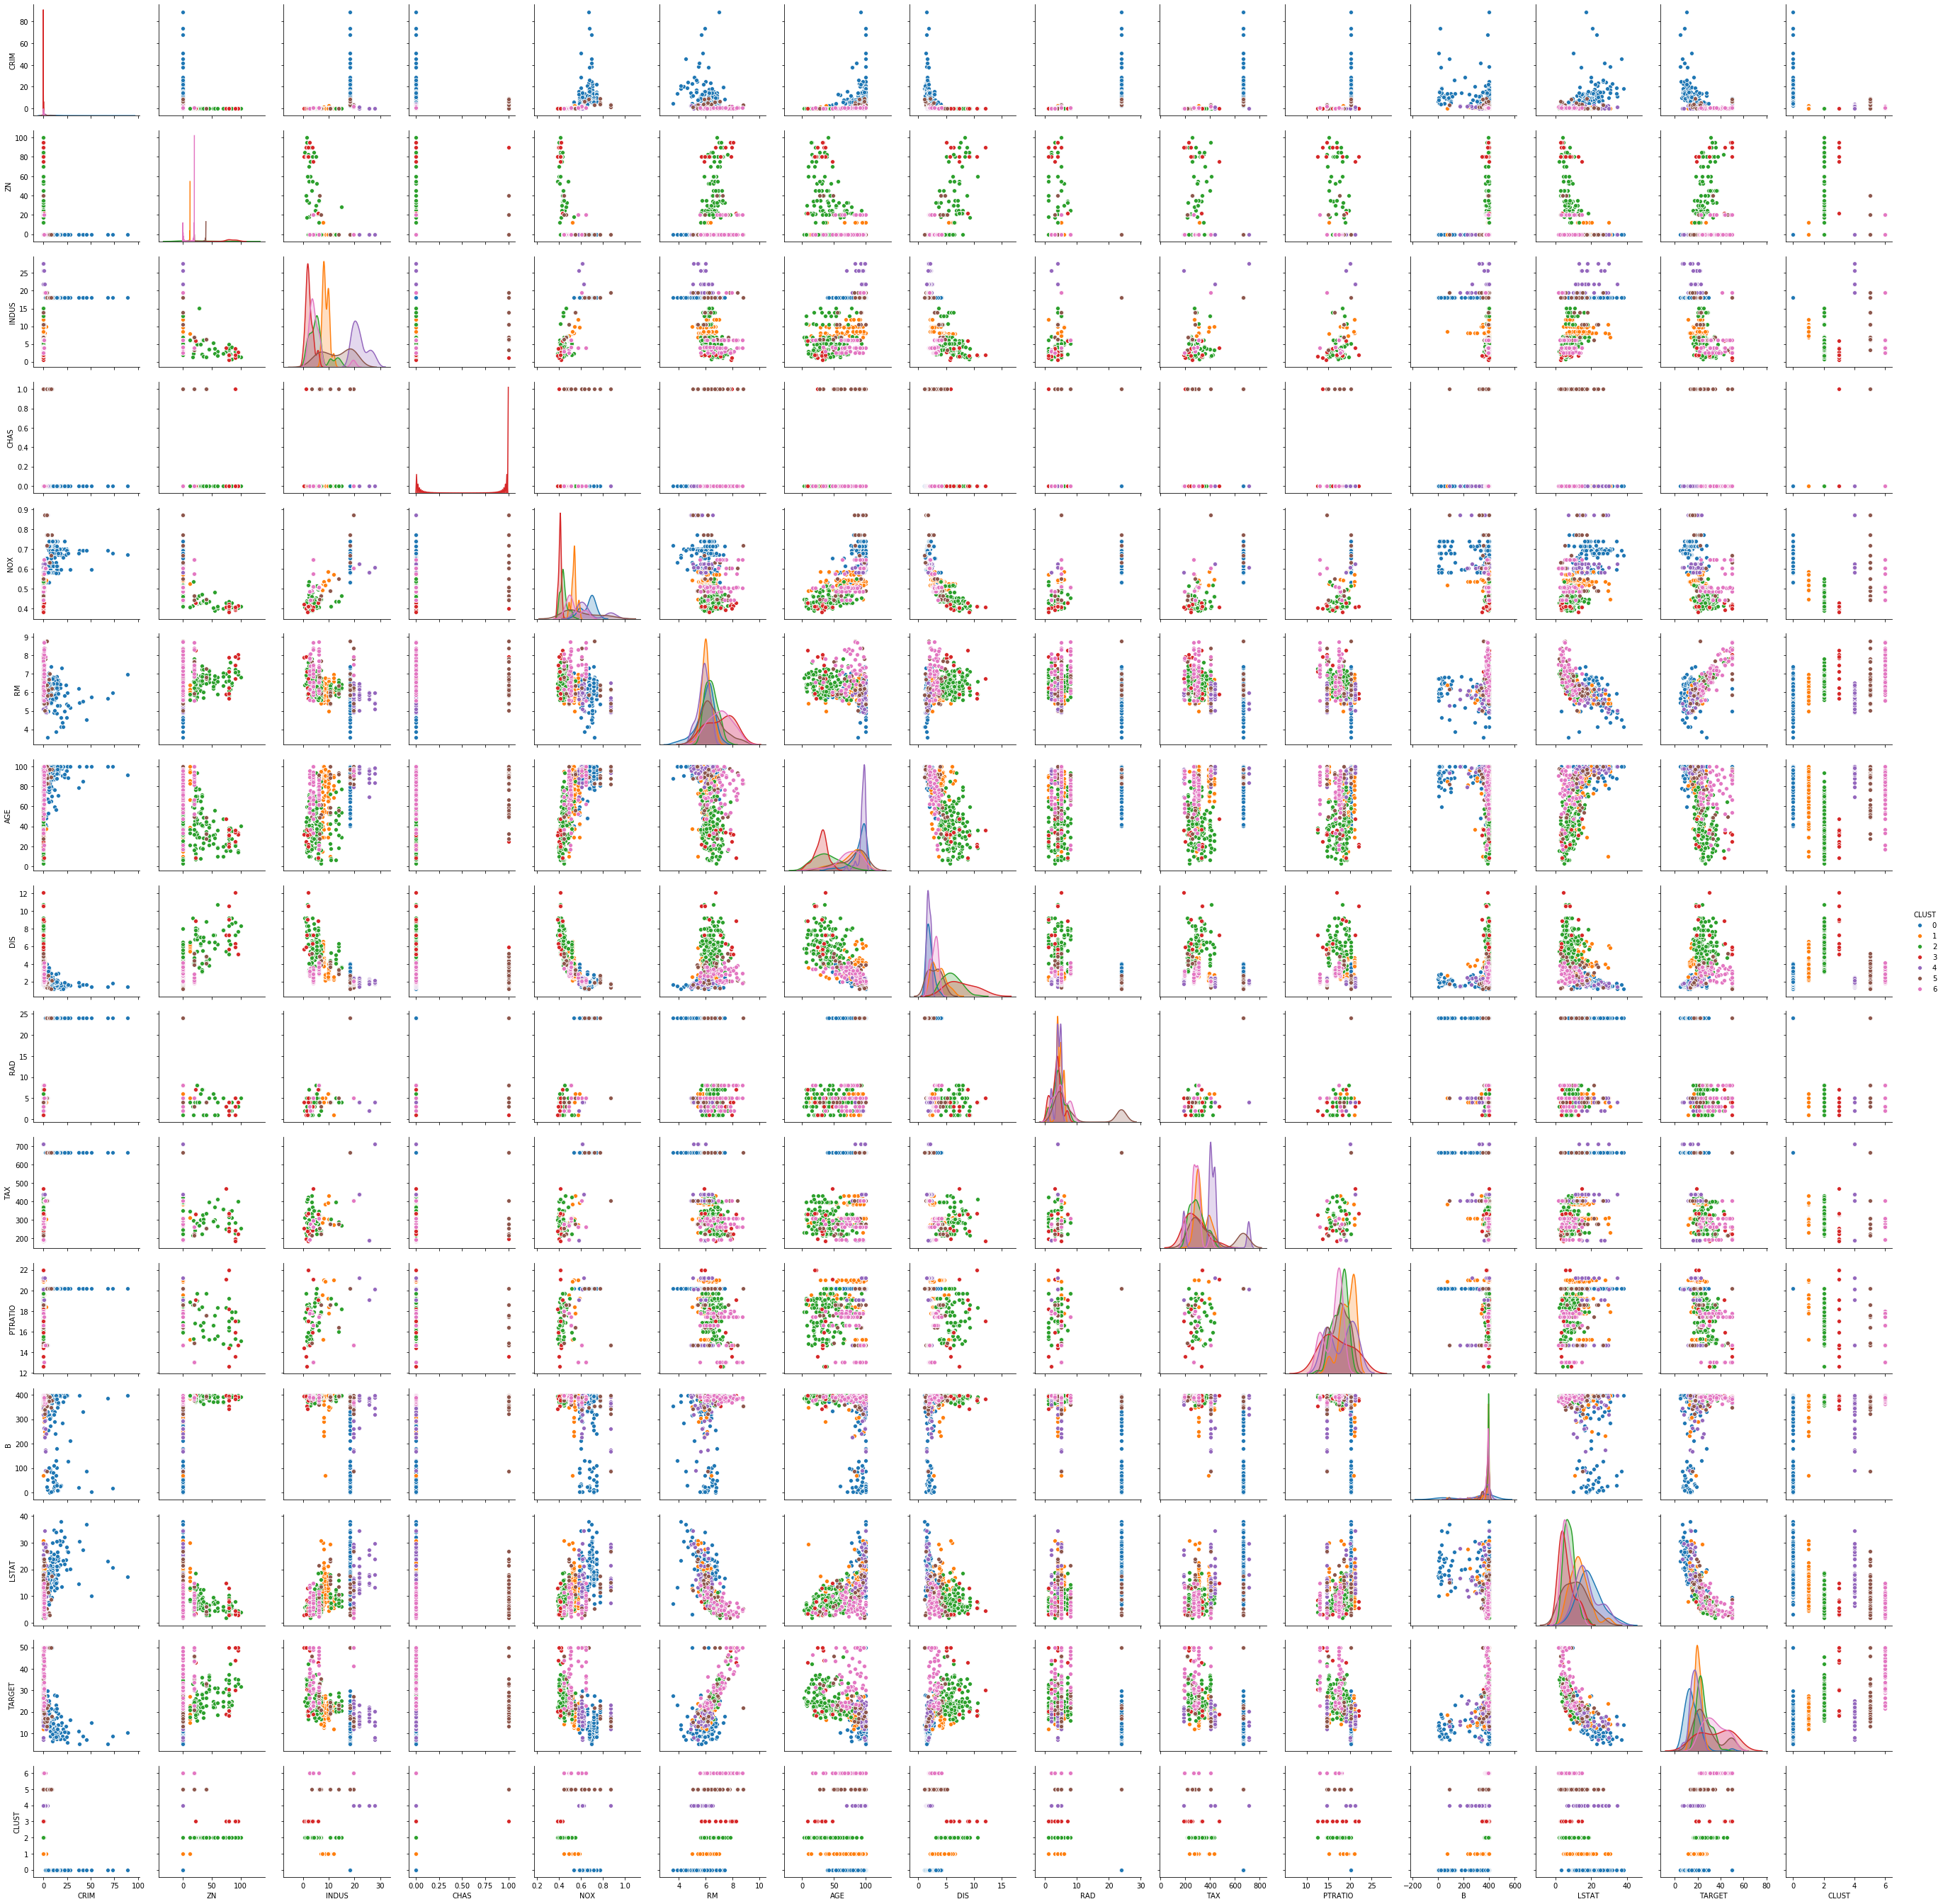

In [44]:
boston_df_em = boston_df.copy()
boston_df_em['CLUST'] = y_em
sns.pairplot(boston_df_em, hue='CLUST')

This scatterplot is even harder to read, because we now have seven clusters instead of three. The density plots indicate that often, many clusters have similar distributions in the features. For example, for AGE, five of the clusters have their peak at almost the same value, the other two clusters also have their peak at almost the same value. Only their variance is a bit different, but also similar. There are only two features, where we can see a good separation between almost all clusters in the density plots: INDUS and NOX. Fortunately, we already have our analysis for the three clusters of $k$-Means, because this helps to understand what happened here.

With the seven clusters, we still have the differentiation between the city center, the outer region of the city and suburbs and rural areas. However, this separation is more finegrained, because there are some suburbs with more industry and traffic and some with less. Just think about a village in which a large factory is located. This shifts INDUS and NOX in comparison to similar villages in which there is no factory. Thus, the EM result is more finegrained and accurate when it comes to differentiating between different kinds of suburbs and regions closer to the city center. Whether this is required depends on the use case. 

We can also look at the mean values of the normal distributions that were fit to the data. 

In [45]:
pd.DataFrame(scaler.inverse_transform(em.means_), columns=boston_df.columns)

CRIM            ZN      INDUS          CHAS       NOX        RM  \
0  13.209833  2.131628e-14  18.100000 -8.326673e-17  0.669605  5.984137   
1   0.442719  1.050973e+00   8.954199 -1.387779e-17  0.537326  6.043697   
2   0.084548  2.765630e+01   5.641546 -4.163336e-17  0.443721  6.416816   
3   0.059578  7.975000e+01   2.480000  8.333334e-02  0.409600  7.079167   
4   1.175292 -1.776357e-15  22.089362 -4.163336e-17  0.675830  5.845809   
5   1.905690  5.294118e+00  13.057647  1.000000e+00  0.599085  6.478324   
6   0.388249  4.722476e+00   5.106270 -1.387779e-17  0.533668  7.097995   

         AGE       DIS        RAD         TAX    PTRATIO           B  \
0  89.731452  2.074494  24.000000  666.000000  20.200000  282.584032   
1  75.021775  3.647576   4.519359  333.645158  19.417505  379.175081   
2  39.083782  5.993622   4.296153  296.376755  17.698690  390.455896   
3  29.808333  7.835667   3.500000  280.750001  17.108333  382.702500   
4  95.140426  1.907649   4.127660  414.595745  18.004255  348.715106   
5  79.050000  2.945729   9.558824  391.794118  17.605882  372.335000   
6  73.895243  2.890533   4.981623  277.753620  16.235409  388.336113   

       LSTAT     TARGET  
0  19.172823  15.438710  
1  13.683432  19.535313  
2   7.922226  25.100947  
3   6.160833  35.291666  
4  17.784255  17.793617  
5  11.479412  27.805882  
6   7.055379  34.762562

The means support our finding that the differences between INDUS and NOX are between all clusters, whereas most other features are similar for multiple clusters. We do not analyze the covariance matrices, because this would mean that we have to consider seven 14x14 matrices. 

## DBSCAN Clustering

Use DBSCAN to cluster the data and find suitable values for $epsilon$ and $minPts$.  Use a combination of knowledge you already have about the data and visualizations. 

We use the scaled data for DBSCAN clustering to account for scale effects. We first plot how the number of core points for different combinations of $epsilon$ and $minPts$.

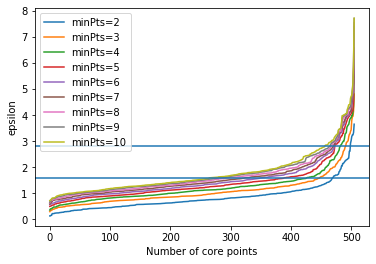

In [71]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

# we use sklearn to find the nearest neighbors
neigh = NearestNeighbors(n_neighbors=10)
nbrs = neigh.fit(boston_scaled)
distances, indices = nbrs.kneighbors(boston_scaled)
for k in range(1, 10):
    distances_k = np.sort(distances[:,k], axis=0)
    plt.plot(distances_k, label='minPts=%i' % (k+1))
    
plt.ylabel('epsilon')
plt.xlabel('Number of core points')
plt.axhline(1.6)
plt.axhline(2.8)
plt.legend()
plt.show()

The horizontal lines mark $epsilon=1.6$ and $epsilon=2.8$, which look like good value for $minPts=2$, respectively $minPts=10$. We now look at the results of DBSCAN for these two combinations in the PCA. 

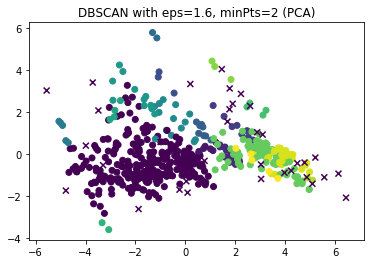

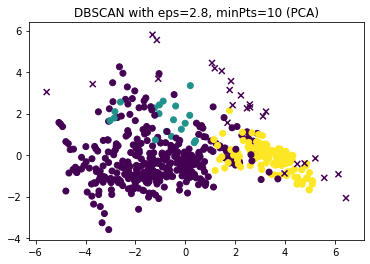

In [19]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1.6, min_samples=2)
dbscan.fit(boston_scaled)
y_dbscan = dbscan.labels_
noise_mask = y_dbscan<0
plt.figure()
plt.scatter(x=boston_pca[~noise_mask,0], y=boston_pca[~noise_mask,1], c=y_dbscan[~noise_mask])
plt.scatter(x=boston_pca[noise_mask,0], y=boston_pca[noise_mask,1], c=y_dbscan[noise_mask], marker='x')
plt.title("DBSCAN with eps=1.6, minPts=2 (PCA)")
plt.show()

dbscan = DBSCAN(eps=2.8, min_samples=10)
dbscan.fit(boston_scaled)
y_dbscan = dbscan.labels_
noise_mask = y_dbscan<0
plt.figure()
plt.scatter(x=boston_pca[~noise_mask,0], y=boston_pca[~noise_mask,1], c=y_dbscan[~noise_mask])
plt.scatter(x=boston_pca[noise_mask,0], y=boston_pca[noise_mask,1], c=y_dbscan[noise_mask], marker='x')
plt.title("DBSCAN with eps=2.8, minPts=10 (PCA)")
plt.show()

The results looks roughly similar. The most notable differences are that there are some very small clusters with $minPts=2$ and that the yellow cluster with $minPts=10$ is split into two clusters with $minPts=2$. These small clusters are likely not real cluster but artifacts due to the small value of $minPts$. Therefore, we continue to analyze the results for $epsilon=2.8, minPts=10$ in greater detail with a pairwise scatterplot. 

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


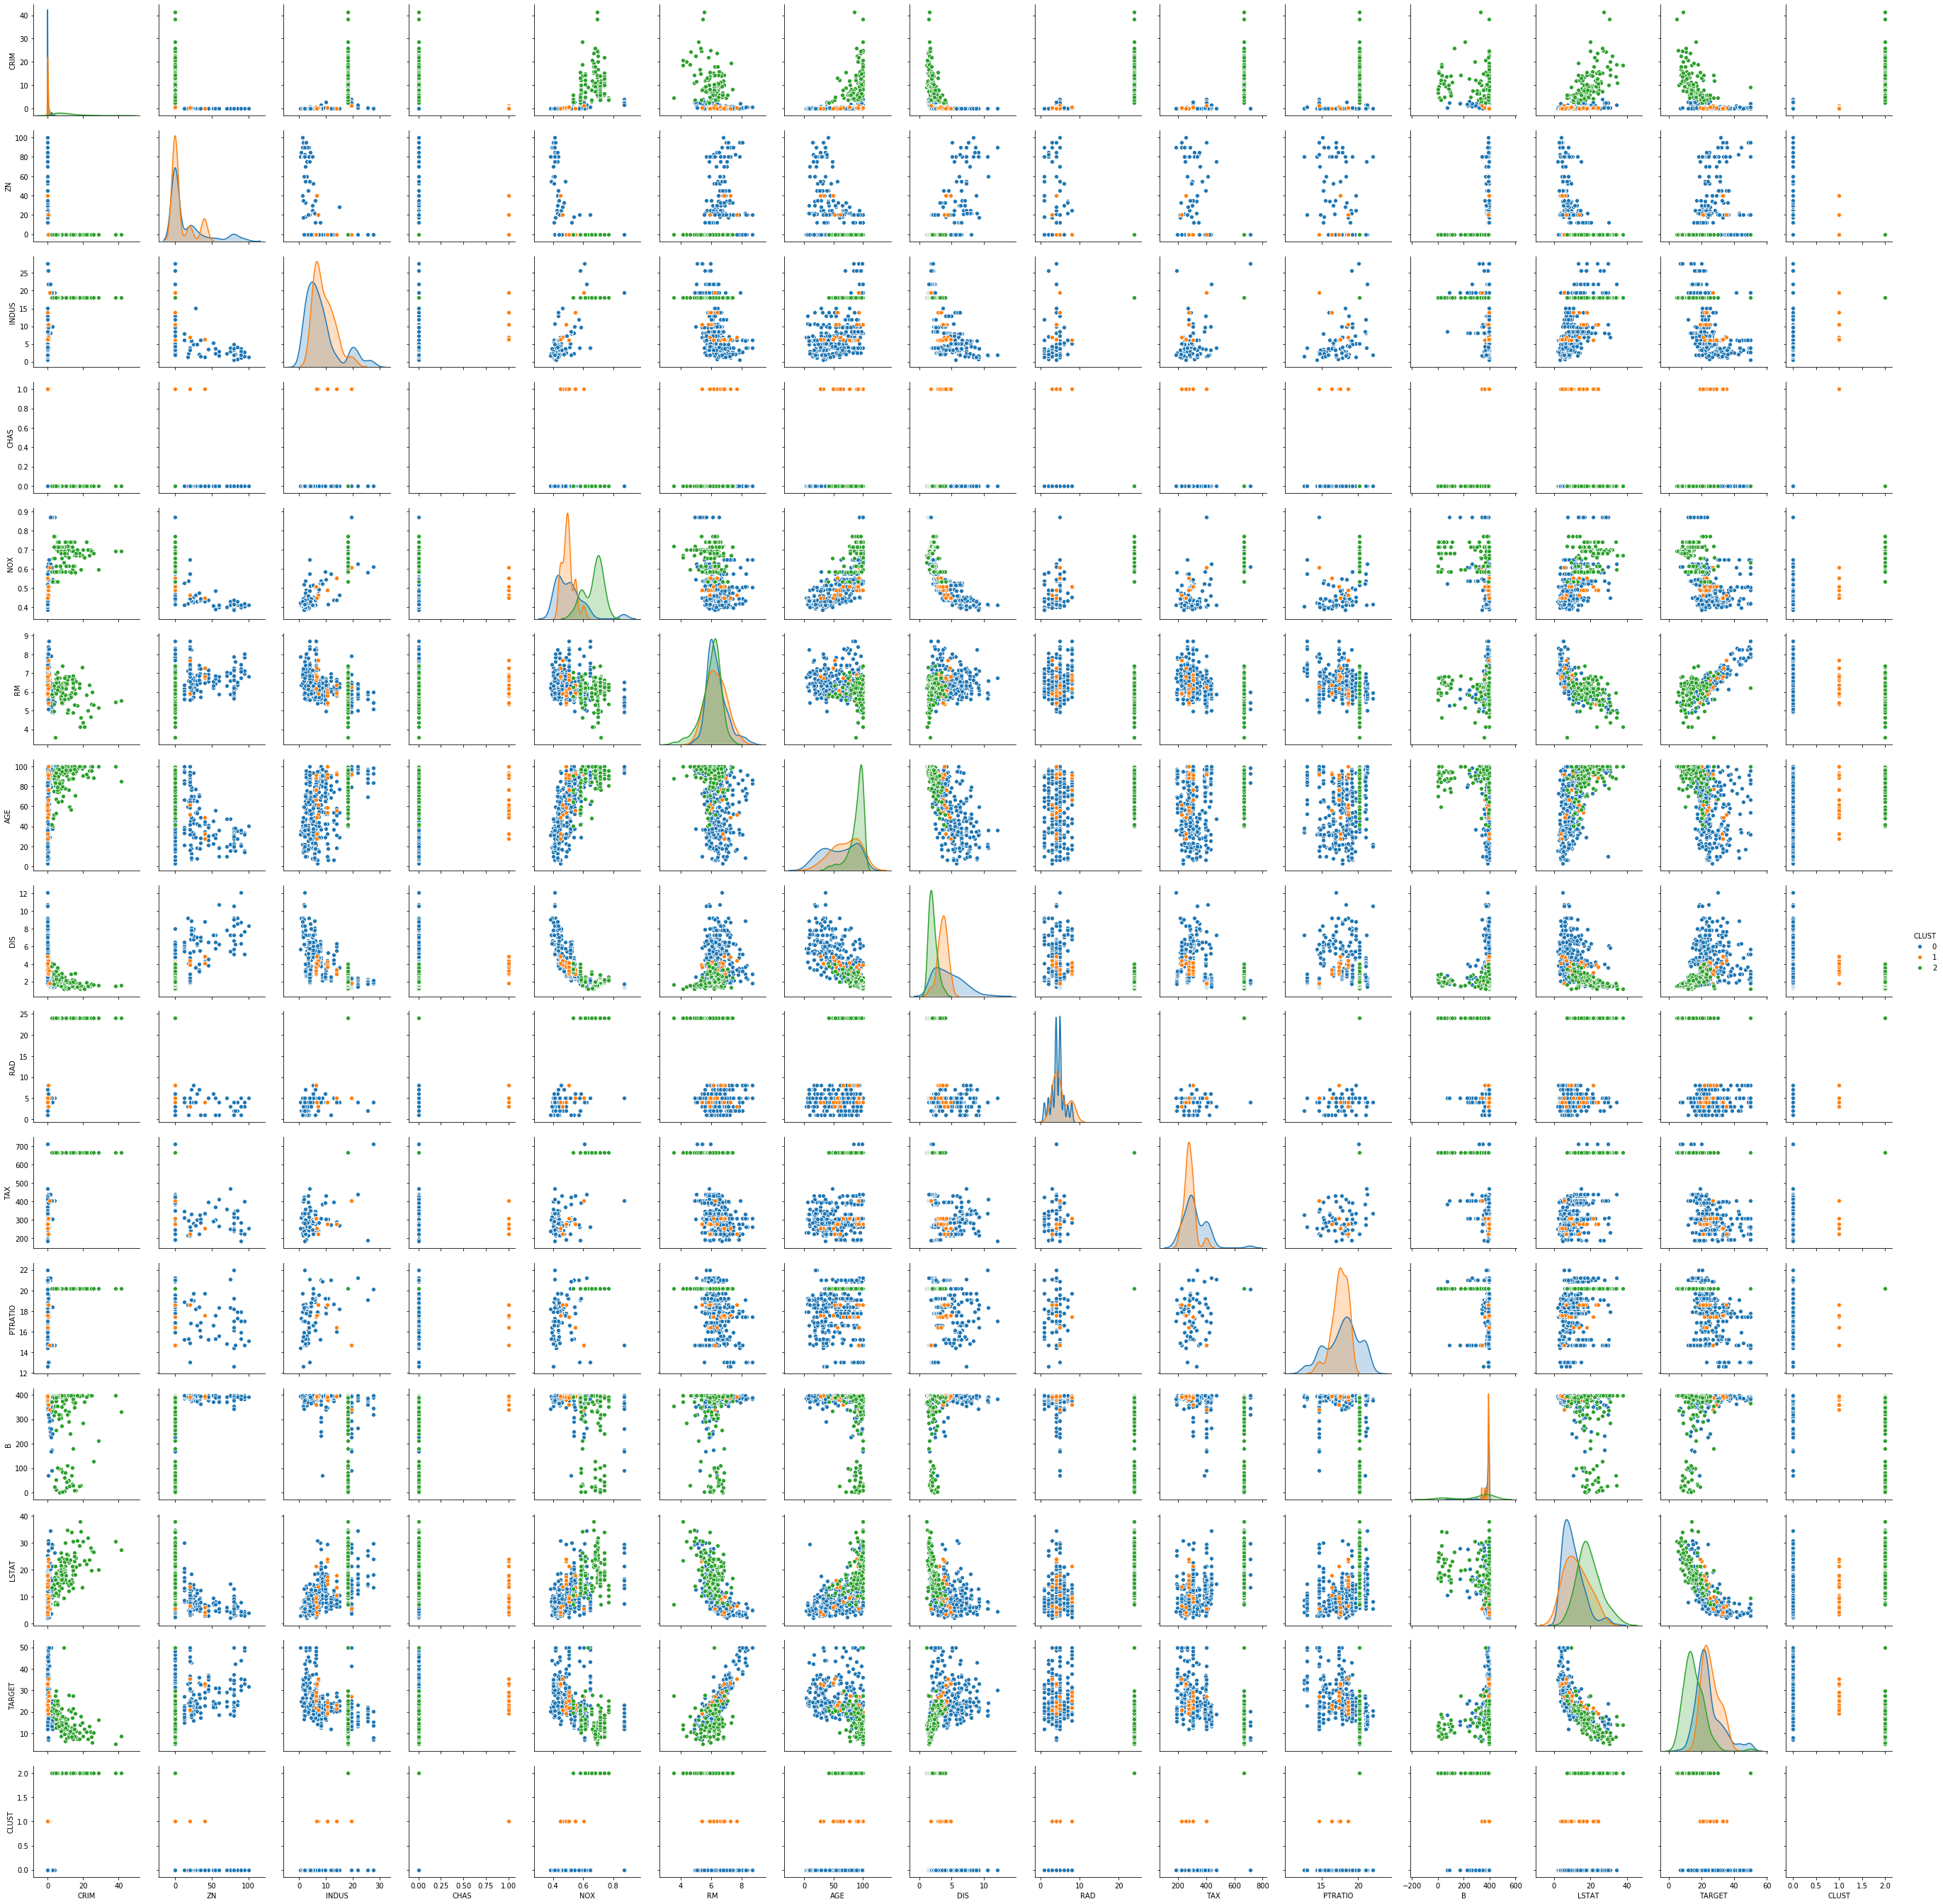

In [74]:
dbscan = DBSCAN(eps=2.8, min_samples=10)
dbscan.fit(boston_scaled)
y_dbscan = dbscan.labels_
noise_mask = y_dbscan<0

boston_df_dbscan = boston_df.copy()
boston_df_dbscan['CLUST'] = y_dbscan
sns.pairplot(boston_df_dbscan[~noise_mask], hue='CLUST')

We see that there are three clusters in our results. Two of these clusters (blue and orange) look very similar, i.e., are very close to each other. These two clusters contain the data for the city centers and regions very close to the city. The green clusters are the suburbs and rural areas. However, there is a difference between this result and the $k$-Means result. While the $k$-Means results strongly separates the city center from the city boundary, this is not the case here. This is due to the way DBSCAN works: since the difference from the city center to the boundary are gradual, there is no real gap between these regions. This means that DBSCAN does not split this into two clusters. Only the outliers in the city boundary, that have a stronger difference can be part of a new cluster. Based on the plot above, these are likely the regions in the city boundary with only few business and a large amount of residents. 

## Hierarchical Clustering

(Note: Hierarchical clustering is also known as agglomerative clustering and can be found under that name in ```sklearn```. This task requires at least ```sklearn``` version 0.22, which is still under development (October 2019). You can find guidance on how to install packages in Jupyter notebook [here](https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/) and regarding the development version of ```sklearn``` [here](https://scikit-learn.org/stable/developers/advanced_installation.html).)

Use hierarchical clustering with single linkage to determine clusters within the housing data. Find a suitable cut-off for the clusters using a dendrogram.

We use the scaled data for Single Linkage (SLINK) clustering to account for scale effects. As a starting point, we use the distance we used for DBSCAN as cutoff, i.e., 2.8 and look at the resulting dendrogram. 

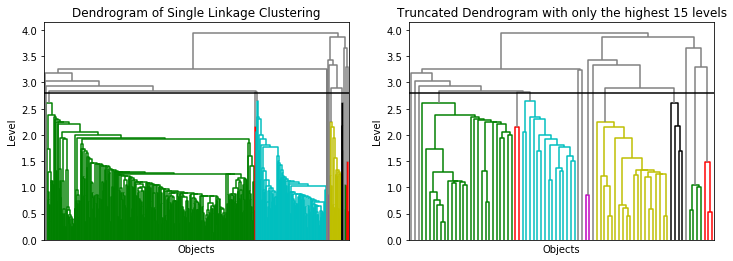

In [12]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

sl = AgglomerativeClustering(n_clusters=None, distance_threshold=2.8, linkage='single', compute_full_tree=True)
sl.fit(boston_scaled)

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

f, axes = plt.subplots(1, 2, sharey=False, sharex=False, figsize=(12, 4))
axes[0].set_title("Dendrogram of Single Linkage Clustering")
axes[0].set_ylabel("Level")
axes[0].set_xlabel("Objects")
plot_dendrogram(sl, no_labels=True, above_threshold_color='grey', ax=axes[0])
axes[0].axhline(y=2.8, c='k')

axes[1].set_title("Truncated Dendrogram with only the highest 15 levels")
axes[1].set_ylabel("Level")
axes[1].set_xlabel("Objects")
plot_dendrogram(sl, no_labels=True, above_threshold_color='grey', p=15, truncate_mode='level', ax=axes[1])
axes[1].axhline(y=2.8, c='k')
plt.show()

The dendrogram shows that this threshold is reasonable. We could even decrease the threshold to 2.6, without changing anything. In the dendrogram without cutoff, we see that most data is within a two clusters (green, tortoise). The dendrogram on the right is misleading with respect to the size of the clusters, because there are many more instance on the lower levels in the green and the tortoise cluster, than in the other clusters. We now look at the results in the PCA to see how well the clusters are separated. 

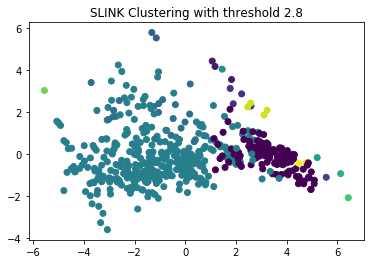

In [15]:
from sklearn.cluster import DBSCAN

sl = AgglomerativeClustering(n_clusters=None, distance_threshold=2.8, linkage='single', compute_full_tree=True)
sl.fit(boston_scaled)
y_sl = sl.labels_

plt.figure()
plt.scatter(x=boston_pca[:,0], y=boston_pca[:,1], c=y_sl)
plt.title("SLINK Clustering with threshold 2.8")
plt.show()

The PCA indicates a good separation, there seems to be a good separation between two big clusters and some very small clusters. This is one major cluster less than we had with DBSCAN. We look at these results in more detail with a pairwise scatterplot. 

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


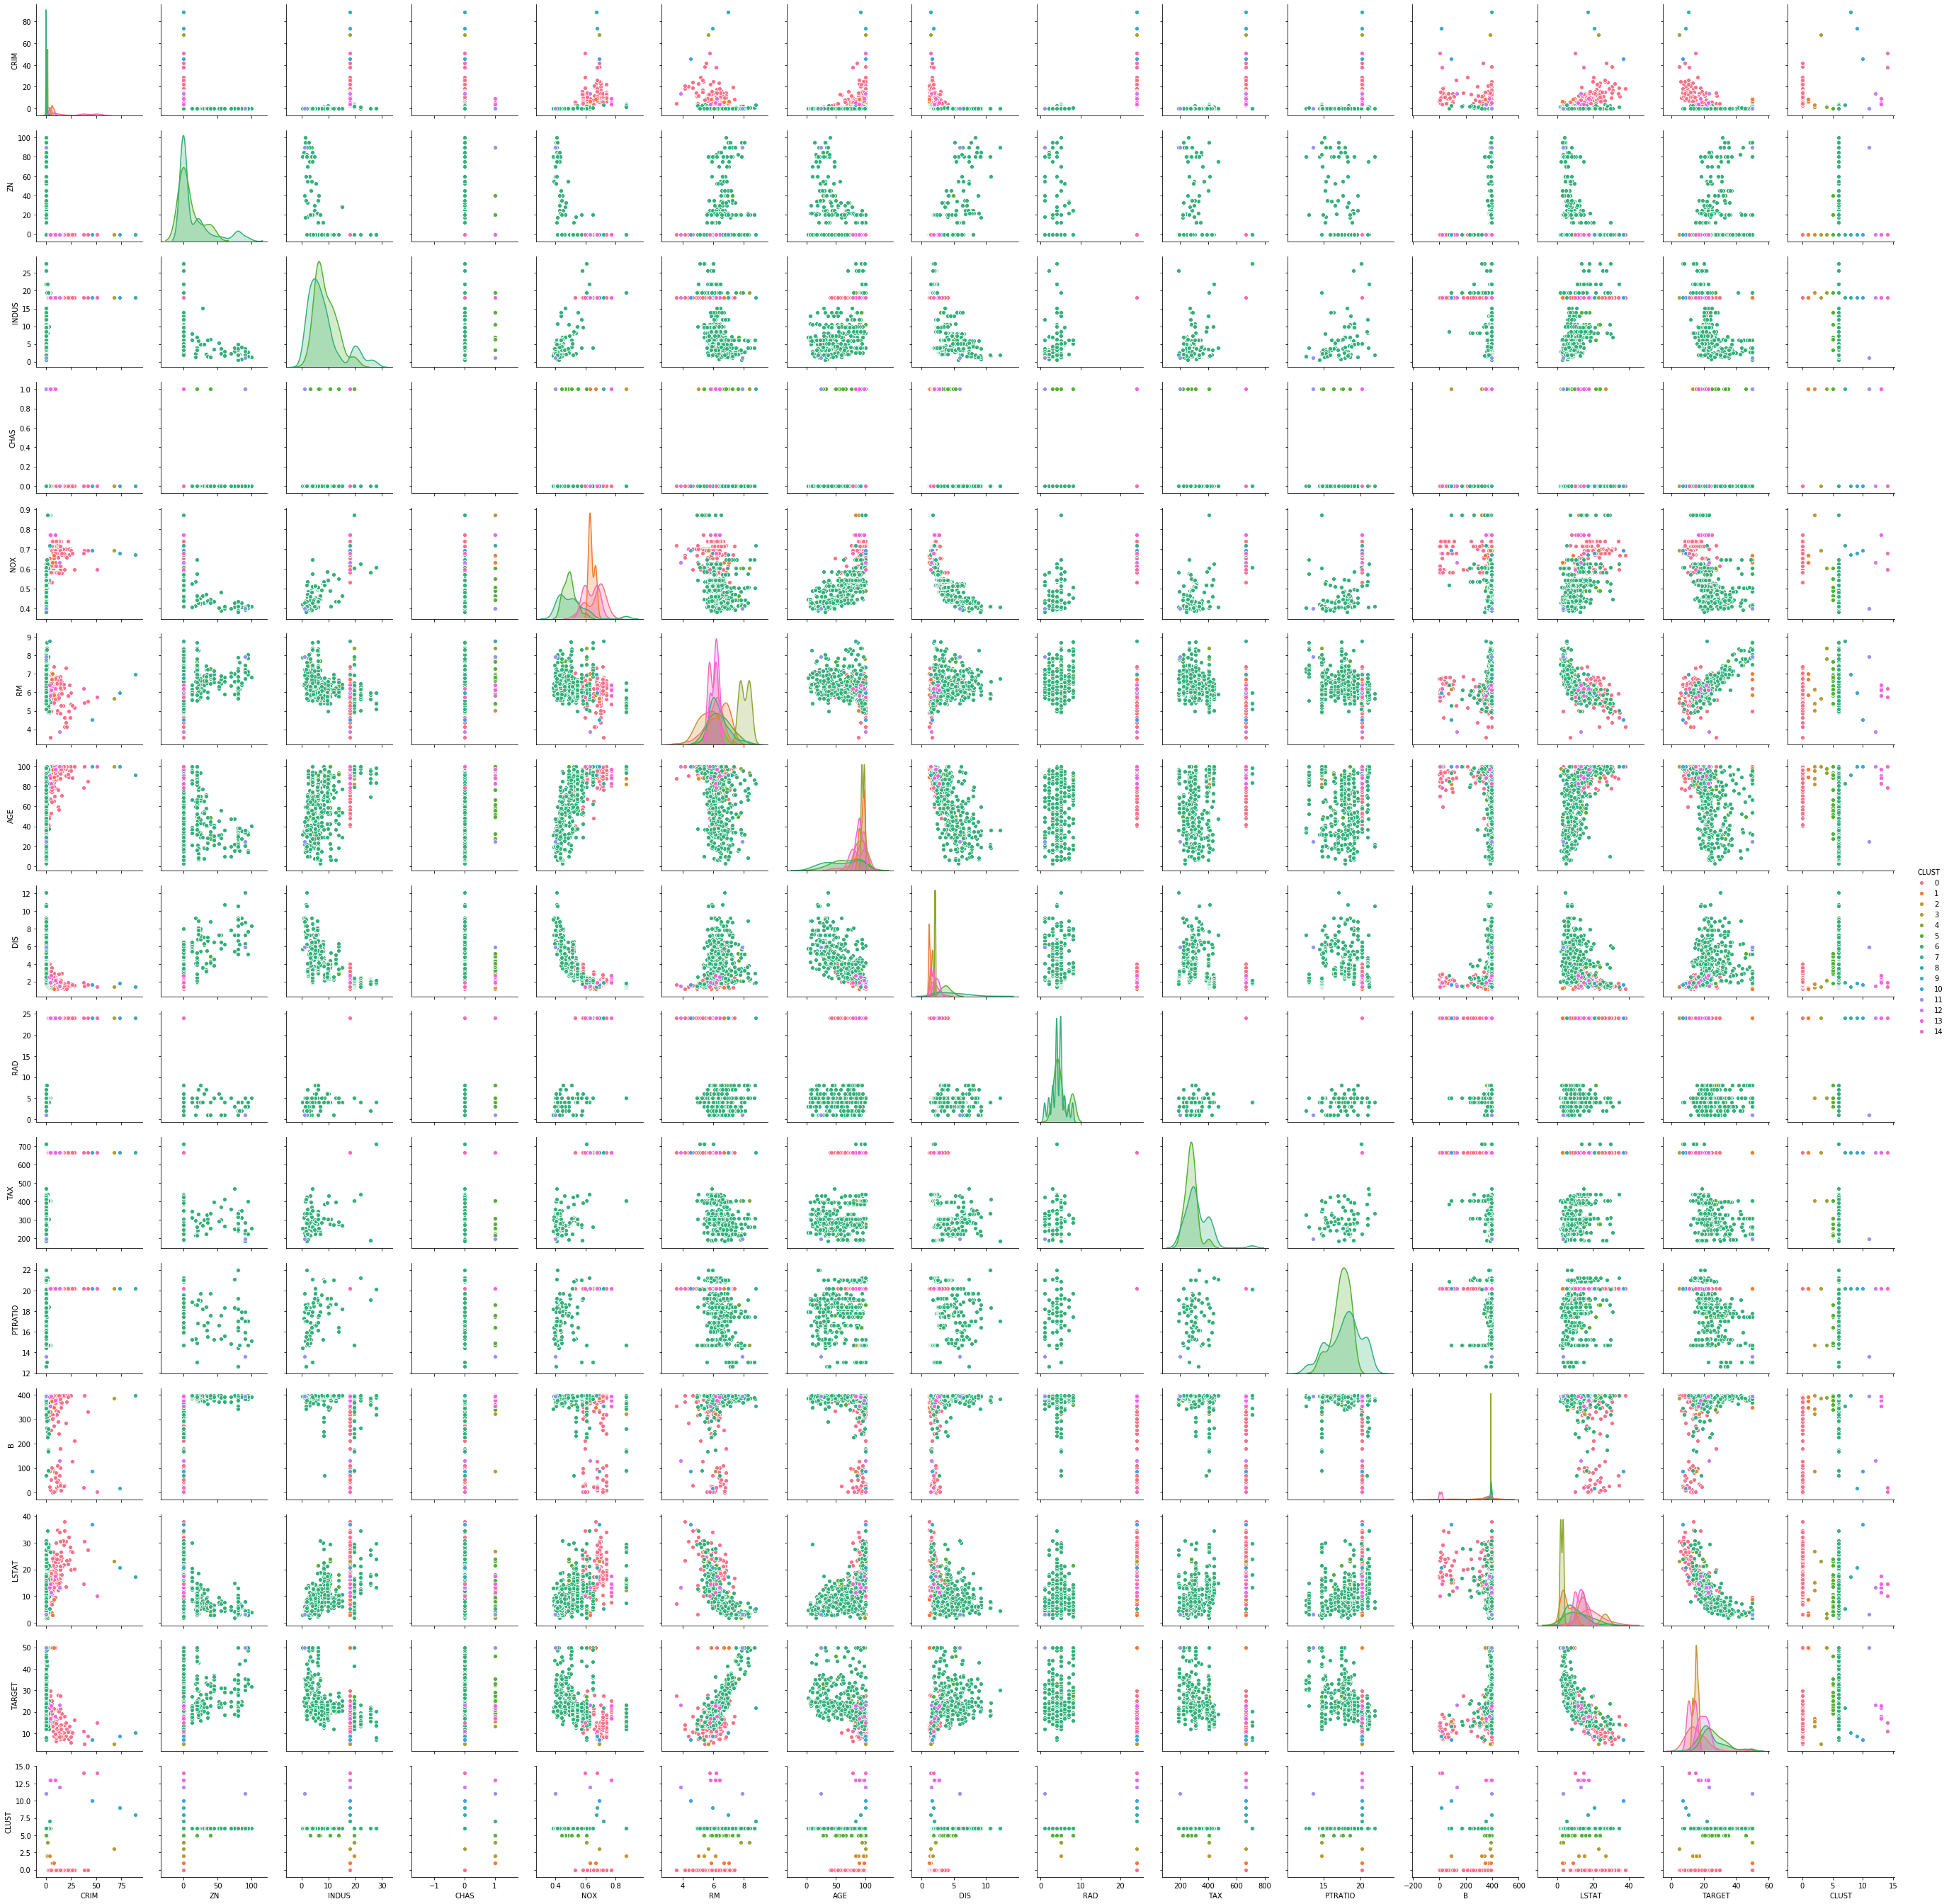

In [21]:
boston_df_sl = boston_df.copy()
boston_df_sl['CLUST'] = y_sl
sns.pairplot(boston_df_sl, hue='CLUST')

The scatterplot confirms that the results of SLINK are roughly similar to those of DBSCAN, which is not surprising because both algorithms consider pairwise distances between instances. However, there is one notable difference and that is that there are only two large clusters left: the city and the boundary of the city is now merged into a single cluster, and the suburbs and rural areas are in the other large cluster. This merge happend because SLINK basically uses $minPts=1$, which means that one similar neighbor is sufficient to not split two regions into distinct clusters. With DBSCAN, we could counter this to some degree with a larger value of $minPts=10$, which led to some split between the city center and the boundary. Another difference between DBSCAN and SLINK are the many very small clusters, which would be noise with DBSCAN. Since SLINK does not use the concept of noise for instances without a dense neighborhood, these are in a small clusters instead. 

## Compare the Clustering Results

How are the clustering results different between the algorithms? Consider, e.g., the number of clusters, the shape of clusters, general problems with using the algorithms, and the insights you get from each algorithm. 

You may also use this to better understand the differences between the algorithms. For example, how are the results from EM clustering different/similar to the results of the $k$-Means clustering? Is there a relationship between the WSS and the BIC? How are the mean values of EM related to the centroids of $k$-Means? What is the relationship between the parameters for DBSCAN and the cut-off for the hierarchical clustering?

The following plots summarize the differences between the clustering results. 

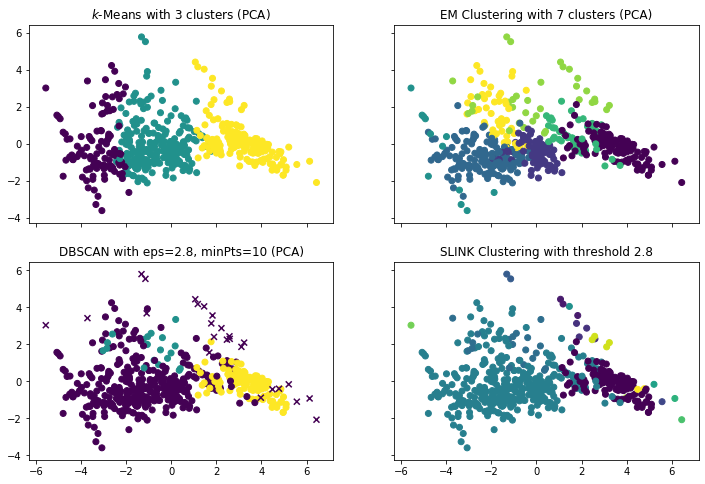

In [20]:
kmeans = KMeans(n_clusters=3, random_state=2)
kmeans.fit(boston_scaled)
y_kmeans = kmeans.predict(boston_scaled)

em = GaussianMixture(n_components=7,random_state=42)
em.fit(boston_scaled)
y_em = em.predict(boston_scaled)

dbscan = DBSCAN(eps=2.8, min_samples=10)
dbscan.fit(boston_scaled)
y_dbscan = dbscan.labels_
noise_mask = y_dbscan<0

sl = AgglomerativeClustering(n_clusters=None, distance_threshold=2.8, linkage='single', compute_full_tree=True)
sl.fit(boston_scaled)
y_sl = sl.labels_

f, axes = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(12, 8))
axes[0,0].scatter(x=boston_pca[:,0], y=boston_pca[:,1], c=y_kmeans)
axes[0,0].set_title("$k$-Means with 3 clusters (PCA)")
axes[0,1].scatter(x=boston_pca[:,0], y=boston_pca[:,1], c=y_em)
axes[0,1].set_title("EM Clustering with 7 clusters (PCA)")
axes[1,0].scatter(x=boston_pca[~noise_mask,0], y=boston_pca[~noise_mask,1], c=y_dbscan[~noise_mask])
axes[1,0].scatter(x=boston_pca[noise_mask,0], y=boston_pca[noise_mask,1], c=y_dbscan[noise_mask], marker='x')
axes[1,0].set_title("DBSCAN with eps=2.8, minPts=10 (PCA)")
axes[1,1].scatter(x=boston_pca[:,0], y=boston_pca[:,1], c=y_sl)
axes[1,1].set_title("SLINK Clustering with threshold 2.8")
plt.show()

We see that we get four different results, but all of them are somewhat similar. The one aspect that is stable for all results is that there is a city region and a suburb/rural region. The difference between the algorithms is how they differentiate within the city region. Except DBSCAN, all algorithm differentiate between different regions within the city. How the differentiate depends on the algorithms. How this compares exactly is already describes within the discussion for each algorithm. 